# Progetto MCS

Per la gestione della struttura dati e le operazioni elementari fra matrici è richiesto di partire da una libreria open-source, come Eigen, Armadillo, blas/lapack. Oppure, qualora il linguaggio di programmazione lo permetta utilizzare vettori e matrici già implementate al suo interno.


## Data Import

Impotazione delle librerie necessarie

In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix, tril
from scipy.sparse.linalg import spsolve_triangular
import matplotlib.pylab as plt
import utils as u

Recupero dei dati

In [2]:
data = {
    "spa1" : 0,
    "spa2" : 0,
    "vem1" : 0,
    "vem2" : 0}
for x in data:
    data[x] = {
        "A" : mmread("data/" + x + ".mtx").tocsr(),
        "x" : 0,
        "b" : 0,
    }
    data[x]["x"] = np.array([1.0]*data[x]["A"].get_shape()[0])
    data[x]["b"] = np.array(data[x]["A"].dot(data[x]["x"]))
resTot = {}

Tolleranze e metodi

In [3]:
## Tolleranze
tols = [10**(-4), 10**(-6), 10**(-8), 10**(-10)]

## Metodi
metods = ["Jacoby", "Gauss-Seidel", "Gradiente", "Gradiente Coniugato"]

Dizionario contente le classi risolutrici

In [4]:
import jacoby_mcs as ja
import gauss_seidel as gs
import gradiente as gr
import gradiente_coniugato as grc

solver = {}
solver["Jacoby"] = ja
solver["Gauss-Seidel"] = gs
solver["Gradiente"] = gr
solver["Gradiente Coniugato"] = grc

Condizione di arresto: $\frac{||Ax^{(k)}-b||}{||b||}<tol$

Reminder: 

1.   **Iniziare le iterazioni con il vettore x nullo**
2.   **tol = [$10^{-4}, 10^{-6}, 10^{-8}, 10^{-10}]$**
3.   **Dichiarare di non essere giunti a convergenza se k > maxiter dove maxiter lo scegliamo (>= 20000)**




### Grafici e informazioni sulle matrici

Impostazione dei grafici

In [5]:
import matplotlib.pylab as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 18]
plt.rcParams['figure.dpi'] = 100

Grafici delle matrici

In [ ]:
i = 221
for mt in data:
    plt.subplot(i)
    plt.spy(data[mt]["A"], markersize = 200/data[mt]["A"].shape[0])
    plt.title("Matrice " + mt, fontsize = 18 )
    i += 1
plt.suptitle("Matrici usate per il progetto", fontsize = 40)

info sulle matrici

In [ ]:
for mt in data:
    den = str(round((100 * data[mt]["A"].nnz) / (data[mt]["A"].shape[0]*data[mt]["A"].shape[1]), 2))
    print("La matrice " + mt + " è una matrice " + str(data[mt]["A"].shape[0]) + "x" + str(data[mt]["A"].shape[1]) + ", contiene " + str(data[mt]["A"].nnz) + " elementi diversi da 0 ed è quindi densa del " + den + "%")

### Preparazione grafico del residuo/errore relativo

In [ ]:
#PRIMA DI ESEGUIRLO CHIAMARE LE FUNZIONI IN FONDO
charts_results = {}
metods = {
    'jacobi': u.jacobi,
    'gauss_seidel': u.gauss_seidel,
    'gradiente': u.gradiente,
    'gradiente_coniugato': u.gradiente_coniugato
}
for metod in metods:    
    charts_results[metod] = {}
    for el in data:
        charts_results[metod][el] = []
        for tol in tols:
            chart_result = metods[metod](data[el]["A"], data[el]["b"], data[el]["x"], tol)
            charts_results[metod][el].append(chart_result)
charts_results



### GRAFICI SU RESIDUI PER NUMERO ITER

In [ ]:
strtols = ["1e-04", "1e-06", "1e-08", "1e-10"]
for metod in metods:
    for el in data:
        plt.plot(charts_results[metod][el][3]["residual_chart"])
        for index, chart in enumerate(charts_results[metod][el]):
            x=len(chart["residual_chart"])
            plt.plot(x, charts_results[metod][el][3]["residual_chart"][x-1], color='red', marker='o')
            plt.text(x, charts_results[metod][el][3]["residual_chart"][x-1], strtols[index], color='black', verticalalignment='bottom')

        # Etichette degli array
        plt.xlabel('ITERAZIONI')
        plt.ylabel('VALORE CRITERIO DI ARRESTO')
        plt.title('VALORI CRITERIO DI ARRESTO PER '+ metod.upper() + ' SULLA MATRICE ' + el.upper() )
        # Mostra il grafico
        plt.rcParams['figure.figsize'] = [15, 12]
        plt.savefig('VALORI CRITERIO DI ARRESTO PER '+ metod.upper() + ' SULLA MATRICE ' + el.upper())
        plt.show()

### GRAFICI SU ERRORI RELATIVI PER NUMERO ITER

In [ ]:
#max_length = max(len(chart["errrel_chart"]) for chart in charts_results['jacobi']['spa1'])
strtols = ["1e-04", "1e-06", "1e-08", "1e-10"]
for metod in metods:
    for el in data:
        plt.plot(charts_results[metod][el][3]["errrel_chart"])
        for index, chart in enumerate(charts_results[metod][el]):
            x=len(chart["errrel_chart"])
            plt.plot(x, charts_results[metod][el][3]["errrel_chart"][x-1], color='red', marker='o')
            plt.text(x, charts_results[metod][el][3]["errrel_chart"][x-1], strtols[index], color='black', verticalalignment='bottom')

        # Etichette degli array
        plt.xlabel('ITERAZIONI')
        plt.ylabel('ERRORE RELATIVO')
        plt.title('ERRORE RELATIVO PER '+ metod.upper() + ' SULLA MATRICE ' + el.upper() )
        plt.rcParams['figure.figsize'] = [15, 12]
        plt.savefig('ERRORE RELATIVO PER '+ metod.upper() + ' SULLA MATRICE ' + el.upper())
        # Mostra il grafico
        plt.show()


## Metodo di Jacobi

$x^{(k+1)} = x^{(k)} + P^{-1}r^{(k)}$

Grafico delle matrici $P^{-1}$

In [13]:
mt = "spa1"
mtxP = 1/data[mt]["A"].diagonal()

ax = np.array(range(1,data[mt]["A"].shape[0]+1))
mtxP = ((mtxP, (ax, ax)), shape=(data[mt]["A"].shape[0], data[mt]["A"].shape[0]))


array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  147,  148,  149,  150,  1

ValueError: not enough values to unpack (expected 2, got 1)

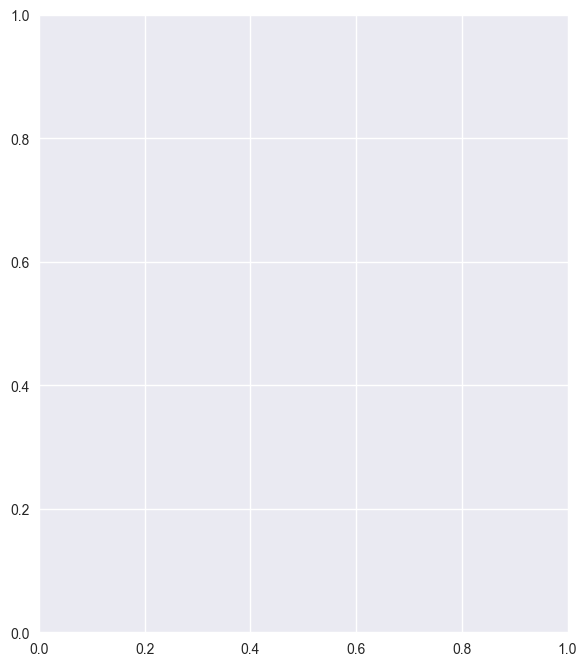

In [6]:
i = 221
for mt in data:
    plt.subplot(i)
    mtxP = 1/data[mt]["A"].diagonal()
    plt.spy(mtxP, markersize = 200/data[mt]["A"].shape[0])
    plt.title(mt, fontsize = 18 )
    i += 1
plt.savefig("data/img/JacobyP.png")

In [ ]:
import jacoby_mcs as ja
method = "Jacoby"
resTot = {}
resTot[method] = {}
for el in data:
    resTot[method][el] = []
    for tol in tols:
        res = ja.solve(data[el]["A"], data[el]["b"], data[el]["x"], tol)
        resTot[method][el].append({
            "tol" : tol,
            "nIter" : res["nIter"],
            "time" : res["time"],
            "eRel" : res["eRel"] 
        })

resTot

## Metodo di Gauß-Seidel

1. $r^{(k)} = b − Ax^{(k)}$
2. Sostituzione in avanti Py = r^{(k)}
3. $x^{(k+1)} = y^{(k)} + y$


Grafico delle matrici $P$

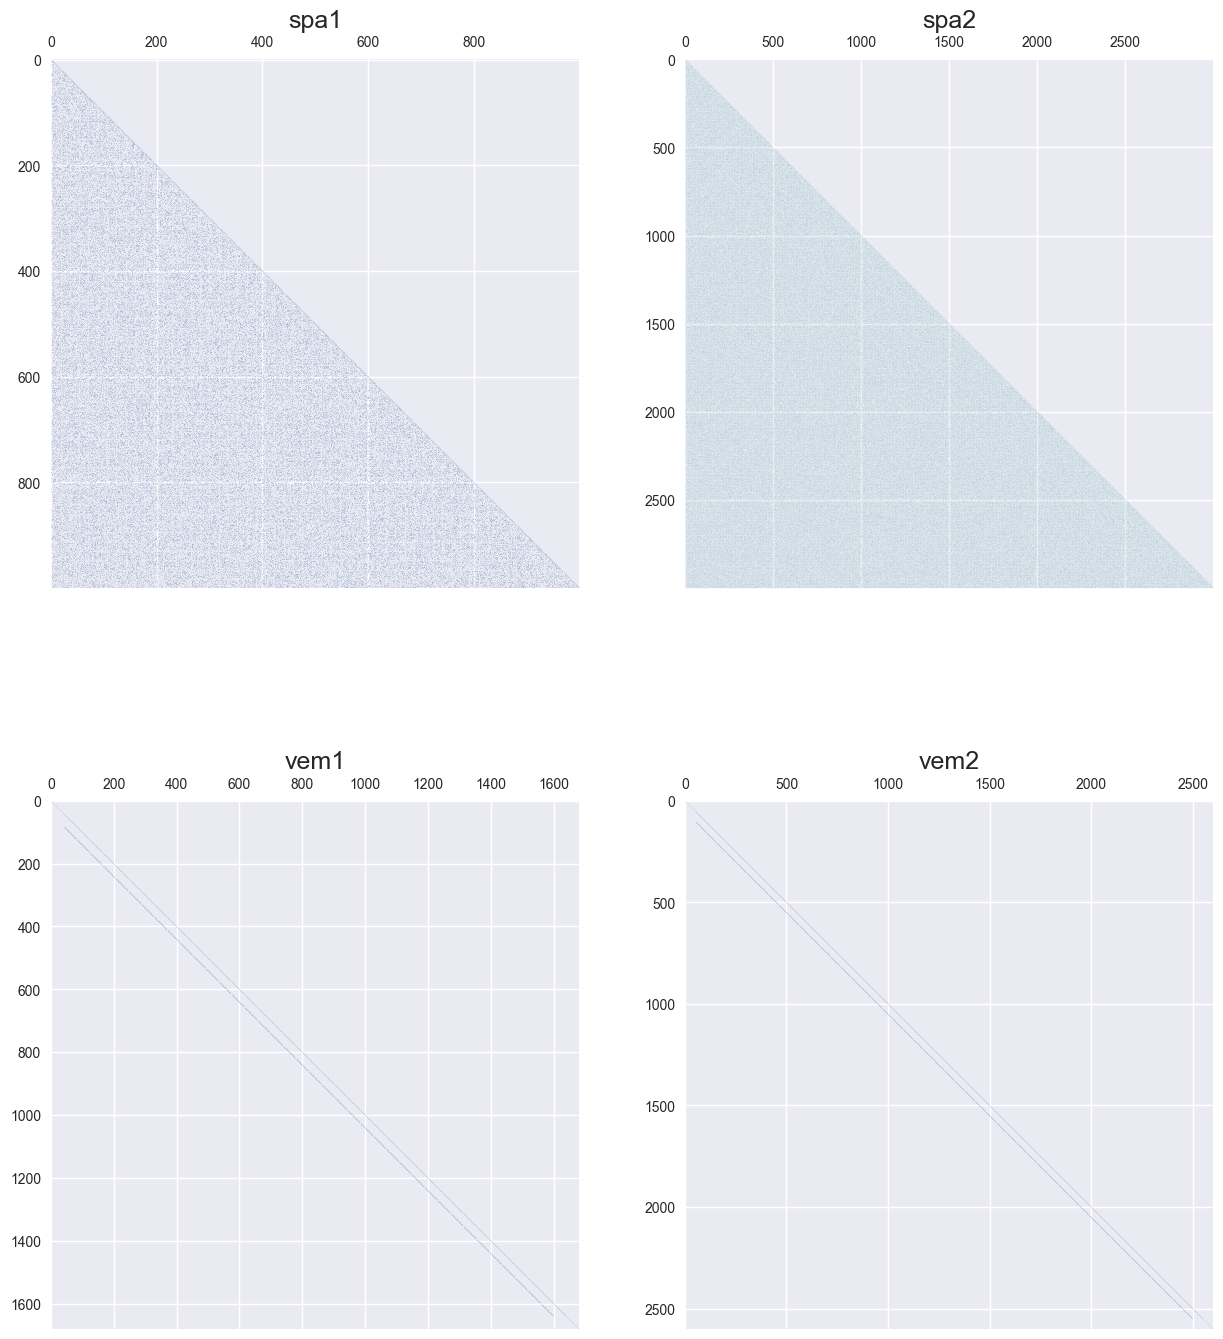

In [7]:
i = 221
for mt in data:
    plt.subplot(i)
    mtxP = tril(data[mt]["A"], format="csr")
    plt.spy(mtxP, markersize = 200/data[mt]["A"].shape[0])
    plt.title(mt, fontsize = 18 )
    i += 1
plt.savefig("data/img/Gauss-SeidelP.png")

In [ ]:
import gauss_seidel as gs
method = "Gauss-Seidel"
resTot[method] = {}
for el in data:
    resTot[method][el] = []
    for tol in tols:
        res = gs.solve(mtxA=data[el]["A"], vectB=data[el]["b"], tol=tol, vectX=data[el]["x"])
        resTot[method][el].append({
            "tol" : tol,
            "nIter" : res["nIter"],
            "time" : res["time"],
            "eRel" : res["eRel"] 
        })

resTot

## Metodo del Gradiente


1. $r^{(k)} = b -Ax^{(k)}$
2. $y^{(k)} = Ar^{(k)}$
3. $a = (r^{(k)})^tr^{(k)}$
4. $b = (r^{(k)})^ty^{(k)}$
5. $\alpha_k = a/b$
6. $x^{(k+1)} = r^{(k)} \alpha_kr^{(k)}$

In [ ]:
import gradiente as gr

method = "Gradiente"
solver = {}
solver[method] = gr
resTot[method] = {}
for el in data:
    resTot[method][el] = []
    for tol in tols:
        res = solver[method].solve(mtxA=data[el]["A"], vectB=data[el]["b"], tol=tol, vectX=data[el]["x"])
        resTot[method][el].append({
            "tol" : tol,
            "nIter" : res["nIter"],
            "time" : res["time"],
            "eRel" : res["eRel"] 
        })
resTot

## Metodo del Gradiente coniugato

- Un vettore ottimale rispetto a una direzione d se d*r(k)=0
- x(k+1) è ottimale rispetto a r(k+1)
- x(k+1) = x(k) + a(k)d(k)
- a(k) = ( d(k)^t * r(k) ) / ( d(k)^t * Ad(k) )
- d(k+1) = r(k+1) - b(k)*d(k)
- b(k) = ( d(k)^t * Ar(k+1) ) / ( d(k)^t * Ad(k) )



In [ ]:
import gradiente_coniugato as grc
method = "Gradiente Coniugato"
resTot = {}
resTot[method] = {}
for el in data:
    resTot[method][el] = []
    for tol in tols:
        res = grc.solve(data[el]["A"], data[el]["b"], data[el]["x"], tol)
        resTot[method][el].append({
            "tol" : tol,
            "nIter" : res["nIter"],
            "time" : res["time"],
            "eRel" : res["eRel"] 
        })

resTot

## Risultati totali

In [ ]:
resTot = {}
for mth in solver:    
    resTot[mth] = {}
    for el in data:
        resTot[mth][el] = []
        for tol in tols:
            res = solver[mth].solve(mtxA=data[el]["A"], vectB=data[el]["b"], tol=tol, vectX=data[el]["x"])
            resTot[mth][el].append({
                "tol" : tol,
                "nIter" : res["nIter"],
                "time" : res["time"],
                "eRel" : res["eRel"] 
            })
resTot

### Grafici

In [ ]:
import json
with open("Results.json", 'r') as file:
    resTot = json.load(file)

### Grafici di ogni matrice

Confronto dei metodi su una singola matrice

In [ ]:
stmDF = {} # Stampe DataFrame
stmDF["Tempistiche"] = {}
stmDF["Iterazioni"] = {}
stmDF["Errore Relativo"] = {}
br = {}

for mt in data:
    br[mt] = {}
    stmDF["Tempistiche"][mt] = {}
    stmDF["Iterazioni"][mt] = {}
    stmDF["Errore Relativo"][mt] = {}
for mth in resTot:
    for mt in resTot[mth]:
        br[mt][mth] = []
        stmDF["Tempistiche"][mt][mth] = []
        stmDF["Iterazioni"][mt][mth] = []
        stmDF["Errore Relativo"][mt][mth] = []
        for el in resTot[mth][mt]:
            stmDF["Tempistiche"][mt][mth].append(el["time"])
            stmDF["Iterazioni"][mt][mth].append(el["nIter"])
            stmDF["Errore Relativo"][mt][mth].append(el["eRel"])
    
barWidth = 1/(len(solver)+1)


for mtx in br:
    ks = list(br[mtx].keys())
    br[mtx][ks[0]] = np.arange(len(tols))
    for i in range(1, len(br[mtx])):
        br[mtx][ks[i]] = [round(x + barWidth, 2) for x in br[mtx][ks[i-1]]]

colors = ["r", "g", "b", "y"]

mts = list(data.keys())

plt.rcParams['figure.figsize'] = [9, 6]

In [ ]:
for tp in stmDF: #tp = type
    for mtx in stmDF[tp]:
        i = 0
        for mth in stmDF[tp][mtx]:
            plt.bar(br[mtx][mth], stmDF[tp][mtx][mth], 
                color = colors[i], width = barWidth,
                edgecolor ='grey', label =mth)
            for j in range(len(br[mtx][mth])):
                if tp == "Tempistiche":
                    stm = u.printTime(stmDF[tp][mtx][mth][j])
                elif tp == "Errore Relativo":
                    stm = format(stmDF[tp][mtx][mth][j], ".1e")
                else:
                    stm = str(stmDF[tp][mtx][mth][j])
                plt.text( br[mtx][mth][j], stmDF[tp][mtx][mth][j], stm, ha='center', va="bottom", rotation=45 )
            i += 1
        plt.xlabel('Tolleranze', fontweight ='bold', fontsize = 15)
        plt.ylabel(tp, fontsize = 15)
        plt.xticks([r + barWidth for r in range(len(tols))], tols)
        plt.title(mtx)
    
        
        plt.legend()
        # plt.savefig("data/img/" + tp + " " + mtx + ".png")
        plt.show()

### Grafici di ogni metodo

Confronto sulle varie matrici di ogni singolo metodo 

Recupero dei dati utili per i grafici

In [ ]:
stmDF = {}
for mth in resTot:
    stmDF[mth] = {
        "Tempistiche" : {},
        "Iterazioni" : {},
        "Errore Relativo" : {}
    }
    for tol in tols:
        stmDF[mth]["Tempistiche"][str(tol)] = []
        stmDF[mth]["Iterazioni"][str(tol)] = []
        stmDF[mth]["Errore Relativo"][str(tol)] = []
    for mt in resTot[mth]:
        for el in resTot[mth][mt]:
            stmDF[mth]["Tempistiche"][str(el["tol"])].append(el["time"])
            stmDF[mth]["Iterazioni"][str(el["tol"])].append(el["nIter"])
            stmDF[mth]["Errore Relativo"][str(el["tol"])].append(el["eRel"])
    

Definizioni delle barre

In [ ]:
br = {}
for tol in tols:
    br[str(tol)] = []
barWidth = 1/(len(stmDF[mth]["Tempistiche"])+1)

ks = list(br.keys())
br[ks[0]] = np.arange(len(tols))
for i in range(1, len(br)):
    br[ks[i]] =  br2 = [round(x + barWidth, 2) for x in br[ks[i-1]]]

colors = ["r", "g", "b", "y"]

mts = list(data.keys())

plt.rcParams['figure.figsize'] = [9, 6]

Stampa dei grafici

In [ ]:
for mth in stmDF:
    for tp in stmDF[mth]:
        for i in range(len(tols)):
            plt.bar(br[str(tols[i])], stmDF[mth][tp][str(tols[i])],
                    color = colors[i], width = barWidth,
                        edgecolor ='grey', label =str(tols[i]))
            for j in range(len(br[str(tols[i])])):
                if tp == "Tempistiche":
                    stm = u.printTime(stmDF[mth][tp][str(tols[i])][j])
                elif tp == "Errore Relativo":
                    stm = format(stmDF[mth][tp][str(tols[i])][j], ".1e")
                else:
                    stm = str(stmDF[mth][tp][str(tols[i])][j])
                plt.text( br[str(tols[i])][j], stmDF[mth][tp][str(tols[i])][j], stm, ha='center', va="bottom", rotation=45 )

        plt.xlabel('Matrici', fontweight ='bold', fontsize = 15)
        plt.ylabel(tp, fontsize = 15)
        plt.xticks([r + barWidth for r in range(len(tols))], mts)
        plt.title(mth)

        plt.legend()
        # plt.savefig("data/img/" + mth + " - " + tp + ".png")
        plt.show()

Grafici dei metodi sulle matrici **spa**

In [ ]:
for mth in stmDF:
    for tp in stmDF[mth]:
        for i in range(len(tols)):
            plt.bar(br[str(tols[i])][:2], stmDF[mth][tp][str(tols[i])][:2], 
                color = colors[i], width = barWidth,
                        edgecolor ='grey', label =str(tols[i]))
            for j in range(len(br[str(tols[i])][:2])):
                if tp == "Tempistiche":
                    stm = u.printTime(stmDF[mth][tp][str(tols[i])][j])
                elif tp == "Errore Relativo":
                    stm = format(stmDF[mth][tp][str(tols[i])][j], ".1e")
                else:
                    stm = str(stmDF[mth][tp][str(tols[i])][j])
                plt.text(br[str(tols[i])][j], stmDF[mth][tp][str(tols[i])][j], stm, ha='center', va="bottom")    

        plt.xlabel('Matrici', fontweight ='bold', fontsize = 15)
        plt.ylabel(tp, fontsize = 15)
        plt.xticks([r + barWidth for r in range(len(mts[:2]))], mts[:2])
        plt.title(mth + " ~ SPA")

        plt.legend()
        # plt.savefig("data/img/" + mth + " ~ SPA - " + tp + ".png")
        plt.show()

Grafici dei metodi sulle matrici **vem**

In [ ]:
for mth in stmDF:
    for tp in stmDF[mth]:
        for i in range(len(tols)):
            plt.bar(br[str(tols[i])][:2], stmDF[mth][tp][str(tols[i])][2:], 
                    color = colors[i], width = barWidth,
                        edgecolor ='grey', label =str(tols[i]))
            for j in range(len(br[str(tols[i])][:2])):
                if tp == "Tempistiche":
                    stm = u.printTime(stmDF[mth][tp][str(tols[i])][j])
                elif tp == "Errore Relativo":
                    stm = format(stmDF[mth][tp][str(tols[i])][j], ".1e")
                else:
                    stm = str(stmDF[mth][tp][str(tols[i])][j])
                plt.text(br[str(tols[i])][j], stmDF[mth][tp][str(tols[i])][j+2], stm, ha='center', va="bottom")


        plt.xlabel('Matrici', fontweight ='bold', fontsize = 15)
        plt.ylabel('tempistiche', fontsize = 15)
        plt.xticks([r + barWidth for r in range(len(mts[2:]))], mts[2:])
        plt.title(mth + " ~ VEM")

        plt.legend()
        # plt.savefig("data/img/" + mth + " ~ VEM - " + tp + ".png")
        plt.show()